# Here is the cleaned notebook with only the New Improved RF Algo


In [ ]:
# --- Step 1: Mount your Google Drive ---
# This will prompt you for authorization. Follow the link to get your code.
from google.colab import drive
drive.mount('/content/drive')
print("✅ Google Drive mounted successfully.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted successfully.


In [ ]:
# --- Step 2: Import all necessary libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve, auc, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler # Import RandomUnderSampler
from sklearn.svm import SVC
import joblib
import os
import time
import warnings
from collections import deque # Import deque
from datetime import datetime # Import datetime
warnings.filterwarnings('ignore')


# --- Step 3: Set the path to your dataset in Google Drive ---
# IMPORTANT: Make sure this path exactly matches your folder structure.
DATASET_ROOT_PATH = '/content/drive/MyDrive/Colab Notebooks/dataset'
MODEL_SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/ML_Models/2_RF_Early_Version/RF_Final_Improved.pkl'
SCALER_SAVE_PATH = '/content/drive/MyDrive/Colab Notebook/ML_Models/2_RF_Early_Version/RF_Final_Improved_scaler.pkl'

# Define the base path for saving final models
MODEL_SAVE_DIR = '/content/drive/MyDrive/Colab Notebooks/ML_Models/2_RF_Early_Version'
os.makedirs(MODEL_SAVE_DIR, exist_ok=True) # Ensure the directory exists

In [ ]:
# List available CSV files by walking through the directory and its subdirectories
import os

data_files = []
for dirpath, _, filenames in os.walk(DATASET_ROOT_PATH):
    for f in filenames:
        if f.endswith('.csv'):
            data_files.append(os.path.join(dirpath, f))

print(f"\nFound {len(data_files)} data files")
print("Sample files:", data_files[:5])


# Step 2: Load and combine data
def load_iot_malware_data(sample_size=10000):
    """
    Load N-BaIoT dataset with labels
    sample_size: samples per device/attack type for memory efficiency
    """
    all_data = []

    # Define device types and attack types
    devices = ['Danmini_Doorbell', 'Ecobee_Thermostat', 'Ennio_Doorbell',
               'Philips_B120N10_Baby_Monitor', 'Provision_PT_737E_Security_Camera',
               'Provision_PT_838_Security_Camera', 'Samsung_SNH_1011_N_Webcam',
               'SimpleHome_XCS7_1002_WHT_Security_Camera', 'SimpleHome_XCS7_1003_WHT_Security_Camera']

    attacks = ['gafgyt', 'mirai']  # Focus on Mirai and Gafgyt (BASHLITE)

    # Load benign data
    print("\nLoading benign samples...")
    benign_count = 0
    for device in devices:
        for file in data_files:
            if device in file and 'benign' in file.lower():
                try:
                    df = pd.read_csv(file, nrows=sample_size)
                    df['label'] = 0  # Benign
                    df['device'] = device
                    df['attack_type'] = 'benign'
                    all_data.append(df)
                    benign_count += len(df)
                except Exception as e:
                    continue

    # Load malware data
    print("\nLoading malware samples...")
    malware_count = 0
    for device in devices:
        for attack in attacks:
            for file in data_files:
                if device in file and attack in file.lower():
                    try:
                        df = pd.read_csv(file, nrows=sample_size)
                        df['label'] = 1  # Malware
                        df['device'] = device
                        df['attack_type'] = attack
                        all_data.append(df)
                        malware_count += len(df)
                    except Exception as e:
                        continue

    # Combine all data
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        print(f"\nTotal samples loaded: {len(combined_df)}")
        print(f"Benign: {benign_count}, Malware: {malware_count}")
        print(f"Class balance: {malware_count/(benign_count+malware_count)*100:.1f}% malware")
        return combined_df
    else:
        raise Exception("No data loaded. Please check file paths and contents.")


Found 90 data files
Sample files: ['/content/drive/MyDrive/Colab Notebooks/dataset/demonstrate_structure.csv', '/content/drive/MyDrive/Colab Notebooks/dataset/SimpleHome_XCS7_1003_WHT_Security_Camera/benign_traffic.csv', '/content/drive/MyDrive/Colab Notebooks/dataset/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt_attacks/combo.csv', '/content/drive/MyDrive/Colab Notebooks/dataset/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt_attacks/junk.csv', '/content/drive/MyDrive/Colab Notebooks/dataset/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt_attacks/scan.csv']


In [ ]:
# # Load the data using the function defined previously
# print("Loading N-BaIoT dataset...")
# df = load_iot_malware_data(sample_size=5000)

# print("\nData loaded successfully.")

# **New Improved RF Algo: Consolidated Steps**

This section consolidates all the preprocessing, training, and evaluation steps for the improved Random Forest algorithm, including undersampling, scaling, PCA, training, evaluation, feature importance, and cross-validation.

## Handle Class Imbalance (Random Undersampler)

In [ ]:
# Define the directory where the performance data is saved
PERFORMANCE_SAVE_DIR = '/content/drive/MyDrive/Colab Notebooks/performance_data'
import os
os.makedirs(PERFORMANCE_SAVE_DIR, exist_ok=True) # Ensure the directory exists


# Step 4: Handle class imbalance with RandomUnderSampler
print("\n" + "="*50)
print("HANDLING CLASS IMBALANCE WITH RANDOM UNDERSAMPLER")
print("="*50)

# Apply RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = rus.fit_resample(X_train, y_train)

print(f"Original training set: {X_train.shape}")
print(f"Balanced training set: {X_train_balanced.shape}")
print(f"New class distribution: {pd.Series(y_train_balanced).value_counts().to_dict()}")


HANDLING CLASS IMBALANCE WITH RANDOM UNDERSAMPLER
Original training set: (356000, 115)
Balanced training set: (72000, 115)
New class distribution: {0: 36000, 1: 36000}


## Scale Features

In [ ]:
# Step 4b: Scale features
print("\n" + "="*50)
print("SCALING FEATURES")
print("="*50)

# Instantiate a StandardScaler object.
scaler = StandardScaler()

# Fit the scaler to the balanced training features (from RandomUnderSampler) and transform them.
X_train_scaled = scaler.fit_transform(X_train_balanced)

# Transform the test features using the same fitted scaler.
X_test_scaled = scaler.transform(X_test)

# Print the shapes of X_train_scaled and X_test_scaled to confirm the transformation.
print(f"\nScaled balanced training set shape: {X_train_scaled.shape}")
print(f"Scaled test set shape: {X_test_scaled.shape}")

# Save the scaler for later use in prediction
scaler_filename = os.path.join(MODEL_SAVE_DIR, "iot_malware_undersampled_scaler.pkl")
joblib.dump(scaler, scaler_filename)
print(f"Saved scaler as {scaler_filename}")


SCALING FEATURES

Scaled balanced training set shape: (72000, 115)
Scaled test set shape: (89000, 115)
Saved scaler as /content/drive/MyDrive/Colab Notebooks/ML_Models/2_RF_Early_Version/iot_malware_undersampled_scaler.pkl


## Apply PCA

In [ ]:
# Step 11: Apply PCA to scaled training and testing data

print("\n" + "="*50)
print("APPLYING PCA FOR RANDOM FOREST") # Updated title
print("="*50)

# 1. Import PCA (already imported in setup)
from sklearn.decomposition import PCA

# 2. Apply PCA for Random Forest pipeline
print("\nApplying PCA for Random Forest...")
# Instantiate PCA, retaining 95% variance
pca_rf = PCA(n_components=0.95, random_state=42)

# Fit PCA on scaled RF training data and transform training data
X_train_pca_rf = pca_rf.fit_transform(X_train_scaled)

# Transform scaled RF test data
X_test_pca_rf = pca_rf.transform(X_test_scaled)

print(f"Original RF training shape: {X_train_scaled.shape}")
print(f"PCA-transformed RF training shape: {X_train_pca_rf.shape}")
print(f"Original RF test shape: {X_test_scaled.shape}")
print(f"PCA-transformed RF test shape: {X_test_pca_rf.shape}")
print(f"Number of components retained by RF PCA: {pca_rf.n_components_}")


APPLYING PCA FOR RANDOM FOREST

Applying PCA for Random Forest...
Original RF training shape: (72000, 115)
PCA-transformed RF training shape: (72000, 19)
Original RF test shape: (89000, 115)
PCA-transformed RF test shape: (89000, 19)
Number of components retained by RF PCA: 19


## Train Random Forest with PCA

In [ ]:
# Step 12: Train Random Forest with PCA
print("\n" + "="*50)
print("TRAINING RANDOM FOREST CLASSIFIER WITH PCA")
print("="*50)

# Initialize and train Random Forest
rf_model_pca = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    oob_score=True # Enable Out-of-Bag score calculation
)

# Measure training time
start_time = time.time()
rf_model_pca.fit(X_train_pca_rf, y_train_balanced) # Use PCA-transformed training data
rf_train_time_pca = time.time() - start_time

print(f"Training time (RF with PCA): {rf_train_time_pca:.2f} seconds")
print(f"\nOut-of-Bag Score (RF with PCA): {rf_model_pca.oob_score_:.4f}")

# Optionally, save the trained Random Forest model with PCA
# rf_model_pca_filename = os.path.join(MODEL_SAVE_DIR, "iot_malware_rf_pca_model.pkl")
# joblib.dump(rf_model_pca, rf_model_pca_filename)
# print(f"\nSaved Random Forest model (with PCA) as {rf_model_pca_filename}")


TRAINING RANDOM FOREST CLASSIFIER WITH PCA
Training time (RF with PCA): 24.39 seconds

Out-of-Bag Score (RF with PCA): 0.9994


## Evaluate Random Forest with PCA


EVALUATING RANDOM FOREST (WITH PCA) PERFORMANCE

Accuracy (RF with PCA): 0.9993
F1-score (RF with PCA): 0.9993

Classification Report (RF with PCA):
              precision    recall  f1-score   support

      Benign       0.99      1.00      1.00      9000
     Malware       1.00      1.00      1.00     80000

    accuracy                           1.00     89000
   macro avg       1.00      1.00      1.00     89000
weighted avg       1.00      1.00      1.00     89000



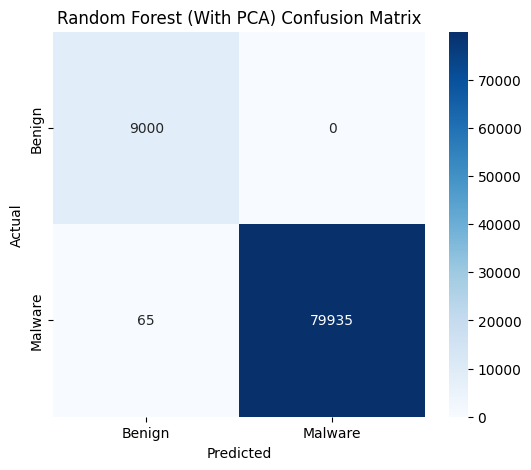


FPR and ROC AUC CALCULATION (RF WITH PCA)

False Positive Rate (FPR): 0.0000
ROC AUC Score: 1.0000


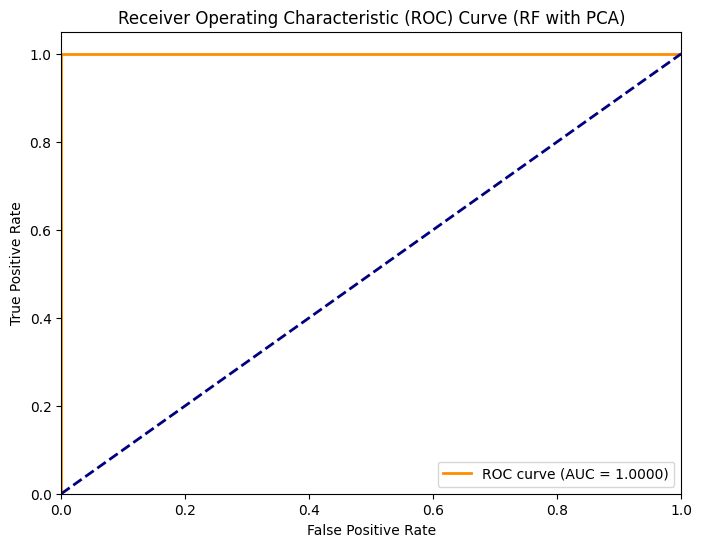

In [ ]:
# Step 13: Evaluate the performance of the Random Forest model with PCA
print("\n" + "="*50)
print("EVALUATING RANDOM FOREST (WITH PCA) PERFORMANCE")
print("="*50)

# Make predictions on the scaled and PCA-transformed test data
rf_pred_pca = rf_model_pca.predict(X_test_pca_rf)

# Calculate accuracy
rf_accuracy_pca = accuracy_score(y_test, rf_pred_pca)

# Calculate weighted F1-score
rf_f1_pca = f1_score(y_test, rf_pred_pca, average='weighted')

# Print accuracy and F1-score
print(f"\nAccuracy (RF with PCA): {rf_accuracy_pca:.4f}")
print(f"F1-score (RF with PCA): {rf_f1_pca:.4f}")

# Generate and print classification report
print("\nClassification Report (RF with PCA):")
print(classification_report(y_test, rf_pred_pca, target_names=['Benign', 'Malware']))

# Generate confusion matrix
cm_rf_pca = confusion_matrix(y_test, rf_pred_pca)

# Visualize confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf_pca, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Malware'], yticklabels=['Benign', 'Malware'])
plt.title('Random Forest (With PCA) Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate FPR and ROC AUC for the Random Forest Model with PCA
print("\n" + "="*50)
print("FPR and ROC AUC CALCULATION (RF WITH PCA)")
print("="*50)

# Calculate False Positive Rate (FPR)
tn, fp, fn, tp = cm_rf_pca.ravel()
fpr_pca = fp / (fp + tn)
print(f"\nFalse Positive Rate (FPR): {fpr_pca:.4f}")

# Calculate ROC AUC Score
try:
    rf_pred_proba_pca = rf_model_pca.predict_proba(X_test_pca_rf)[:, 1] # Get probability of the positive class (Malware=1)
    roc_auc_pca = roc_auc_score(y_test, rf_pred_proba_pca)
    print(f"ROC AUC Score: {roc_auc_pca:.4f}")

    # Optionally, plot the ROC curve
    fpr_curve_pca, tpr_curve_pca, thresholds_pca = roc_curve(y_test, rf_pred_proba_pca)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_curve_pca, tpr_curve_pca, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_pca:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve (RF with PCA)')
    plt.legend(loc="lower right")
    plt.show()

except AttributeError:
    print("\nWarning: The trained model does not have a 'predict_proba' method.")
    print("Cannot calculate ROC AUC score without prediction probabilities.")
except Exception as e:
    print(f"\nAn error occurred during ROC AUC calculation: {e}")

## Feature Importance (Random Forest with PCA)

In [ ]:
# Step 14: Calculate and display feature importance for the Random Forest model with PCA
print("\n" + "="*50)
print("FEATURE IMPORTANCE (RF WITH PCA)")
print("="*50)

# Note: Feature importance from RandomForestClassifier is based on the original features,
# even when trained on PCA components. The PCA transformation is a linear combination
# of original features. Directly interpreting feature importance from the model trained
# on PCA components in terms of original features is not straightforward without
# further analysis of the PCA components themselves.

print("\nDirect feature importance from the model trained on PCA components is based on the components, not original features.")
print("Analyzing feature importance in terms of original features after PCA requires additional steps (e.g., examining PCA component loadings).")

# You can still get importance of the PCA components if needed:
# component_importances = rf_model_pca.feature_importances_
# print("\nImportance of PCA Components (RF with PCA):")
# for i, importance in enumerate(component_importances):
#     print(f"Component {i+1}: {importance:.4f}")

# If you want to link back to original features, you would need to analyze the `pca_rf.components_`
# This is a more advanced step and depends on the goal. For now, we note the limitation.


FEATURE IMPORTANCE (RF WITH PCA)

Direct feature importance from the model trained on PCA components is based on the components, not original features.
Analyzing feature importance in terms of original features after PCA requires additional steps (e.g., examining PCA component loadings).


## Cross-validation (Random Forest with PCA)

In [ ]:
# Step 15: Cross-validation for robustness check (RF with PCA)
print("\n" + "="*50)
print("CROSS-VALIDATION RESULTS (RF WITH PCA)")
print("="*50)

# Perform 5-fold cross-validation using the scaled and PCA-transformed training data
cv_scores_rf_pca = cross_val_score(
    rf_model_pca,
    X_train_pca_rf, # Use PCA-transformed training data
    y_train_balanced,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1 # Use all available cores
)

print(f"Random Forest (With PCA) CV F1-weighted scores: {cv_scores_rf_pca}")
print(f"Mean CV F1-weighted score: {cv_scores_rf_pca.mean():.4f} (+/- {cv_scores_rf_pca.std() * 2:.4f})")


CROSS-VALIDATION RESULTS (RF WITH PCA)
Random Forest (With PCA) CV F1-weighted scores: [0.99951389 0.99944444 0.99916667 0.99916667 0.99930556]
Mean CV F1-weighted score: 0.9993 (+/- 0.0003)


## Save Performance Data (Random Forest with PCA)

In [ ]:
# Step 16: Save performance data for the Random Forest model with PCA
print("\n" + "="*50)
print("SAVING PERFORMANCE DATA (RF WITH PCA)")
print("="*50)

# Define a dictionary to store the performance metrics
rf_pca_performance_data = {
    "model_name": "Random Forest (With PCA)",
    "accuracy": rf_accuracy_pca,
    "f1_score": rf_f1_pca,
    "training_time": rf_train_time_pca,
    "false_positive_rate": fpr_pca,
    "roc_auc_score": roc_auc_pca, # Assuming roc_auc_pca was calculated successfully
    "confusion_matrix": cm_rf_pca.tolist() # Convert numpy array to list for JSON serialization
}

# Save the performance data to a JSON file
rf_pca_performance_filename = os.path.join(PERFORMANCE_SAVE_DIR, "rf_pca_performance.json")
import json
with open(rf_pca_performance_filename, 'w') as f:
    json.dump(rf_pca_performance_data, f, indent=4)

print(f"\nSaved Random Forest (With PCA) performance data to: {rf_pca_performance_filename}")


SAVING PERFORMANCE DATA (RF WITH PCA)

Saved Random Forest (With PCA) performance data to: /content/drive/MyDrive/Colab Notebooks/performance_data/rf_pca_performance.json


# **CELL: TO SAVE THE BEST MODEL:**

In [ ]:
# Step 9a: Save the best performing Random Forest model and scaler
print("\n" + "="*50)
print("SAVING BEST RANDOM FOREST MODEL AND SCALER")
print("="*50)

# Define the base path for saving models
MODEL_SAVE_DIR = '/content/drive/MyDrive/Colab Notebooks/ML_Models/3_RF_Improved_Version'
os.makedirs(MODEL_SAVE_DIR, exist_ok=True) # Ensure the directory exists

# Define filenames for the model and scaler within the save directory
rf_model_filename = os.path.join(MODEL_SAVE_DIR, "iot_malware_rf_undersampled_model.pkl")
scaler_filename = os.path.join(MODEL_SAVE_DIR, "iot_malware_undersampled_scaler.pkl")

# Save the trained Random Forest model (the undersampled one)
joblib.dump(rf_model_undersampled, rf_model_filename)
print(f"\nSaved Random Forest model (Undersampled) as {rf_model_filename}")

# Save the scaler fitted on the undersampled training data
joblib.dump(scaler, scaler_filename)
print(f"Saved scaler as {scaler_filename}")

print("\nModel and scaler saved successfully for deployment.")


SAVING BEST RANDOM FOREST MODEL AND SCALER

Saved Random Forest model (Undersampled) as /content/drive/MyDrive/Colab Notebooks/ML_Models/3_RF_Improved_Version/iot_malware_rf_undersampled_model.pkl
Saved scaler as /content/drive/MyDrive/Colab Notebooks/ML_Models/3_RF_Improved_Version/iot_malware_undersampled_scaler.pkl

Model and scaler saved successfully for deployment.
